In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
import os

import sys
sys.path.append('../')
import plotting_functions as pf
import model_utils as mu
import data_utils as du

In [2]:
plot_specs = {'save': True,
              'show': False,
              'save_dir': './figures/'}

In [3]:
dim_input = 4  # Input dimension = `label_tensor.size(1)`
dim_context = 3
dim_features_per_context = int(2**(math.log(dim_input,2)+1) - 1)
batch_size = dim_input * dim_context

In [4]:
# network
n_hidden_layers = 1
gate_output = False

# data
symmetric_contexts = False
separate_contexts = False
append = False

# novel stimuli
# held_out = [(i * dim_input) - 1 for i in range(2, dim_context+1)]
held_out = []

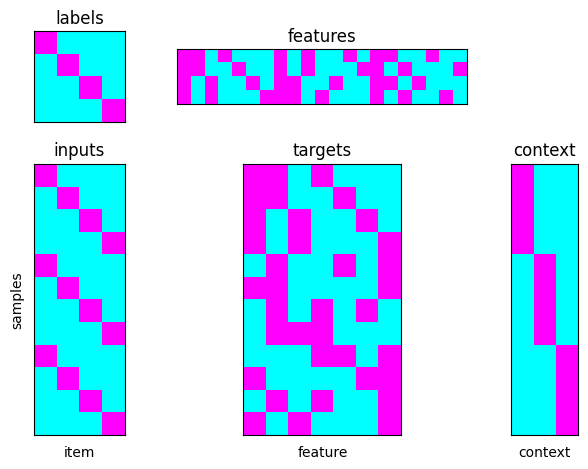

In [5]:
tree_labels, tree_features_all = du.hsd_context(n_items=dim_input, n_contexts=dim_context, 
                                                symmetry=symmetric_contexts)
label_tensor, feature_tensor, context_tensor = du.get_batch(tree_labels, tree_features_all, dim_context, 
                                                            separation=separate_contexts)

if append:
    appendable = torch.split(torch.Tensor(tree_features_all), dim_features_per_context, dim=1)
    appendable = torch.cat(appendable, dim=0)
    feature_tensor = torch.cat((appendable, feature_tensor), dim=1)
    dim_output = dim_features_per_context * (dim_context+1)

pf.plot_inputs_targets_contexts(label_tensor, feature_tensor, context_tensor, held_out, labels=tree_labels, 
                                features=tree_features_all, plot_specs=plot_specs)

In [6]:
import itertools as it

from GLNNet import GLNNet, train

cat = False
if cat:
    label_tensor_ = torch.cat((context_tensor, label_tensor), dim=1)
else:
    label_tensor_ = label_tensor
dim_input_gated = label_tensor_.shape[1]
dim_input_relu = label_tensor.shape[1]

dim_hidden = 30  # Hidden neurons
dim_output = feature_tensor.shape[1] #dim_features_per_context * dim_context if separate_contexts else dim_features_per_context

dims_gated = (dim_input_gated, dim_hidden*(dim_context+1), dim_output)
dims_relu = (dim_input_relu, dim_hidden*(dim_context+1), dim_output)

gateable_layers = [1]
pathways = (1,dim_context+1,1)

mainlist = [i for i in range(1,dim_context+1)]
mapping = [[0] + list(comb) for comb in it.combinations(mainlist, len(mainlist)-1)]        
print('mapping:\t', mapping)

mapping:	 [[0, 1, 2], [0, 1, 3], [0, 2, 3]]


In [7]:
cat = True

tensor([5.9161e+00, 1.7321e+00, 1.0000e+00, 1.0000e+00, 7.8953e-08, 0.0000e+00,
        0.0000e+00])


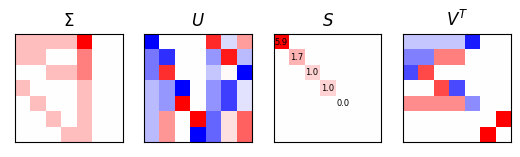

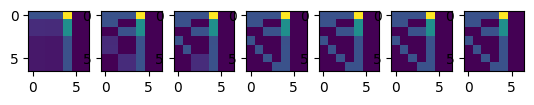

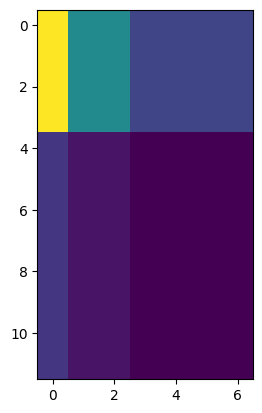

In [8]:
y_split = torch.split(feature_tensor, 4, dim=0)
x = label_tensor
if cat:
    x = torch.cat((x, context_tensor), dim=1)
x_split = torch.split(x, 4, dim=0)

sigmas = [(y.T @ x) for y,x in zip(y_split, x_split)]

k = 0
U, S_, V = torch.svd(sigmas[k])
print(S_)
n_val = len(S_)

fig, axes = plt.subplots(1,4)

sigma = sigmas[k].detach().numpy()
U = U.detach().numpy()
S = torch.diag(S_).detach().numpy()
V = V.detach().numpy()

axes[0].imshow(sigma, cmap='bwr', vmin=-np.max(sigma))
axes[0].title.set_text(r'$\Sigma$')
axes[1].imshow(U, cmap='bwr', vmin=-np.max(U))
axes[1].title.set_text(r'$U$')
axes[2].imshow(S, cmap='bwr', vmin=-np.max(S), vmax=np.max(S))
axes[2].title.set_text(r'$S$')
axes[3].imshow(V.T, cmap='bwr', vmin=-np.max(V))
axes[3].title.set_text(r'$V^T$')
for (j,i), label in np.ndenumerate(S):
    if label != 0:
        axes[2].text(i,j, ("%.1f" % label),ha='center',va='center', fontsize=6)

for ax in axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

fig, axes = plt.subplots(1, n_val)
mat_sum = np.zeros_like(np.outer(U[:,0], V[:,0]))
for i in range(n_val):
    mat = np.outer(U[:,i], V[:,i])
    mat_sum += S_[i].numpy() * mat
    axes[i].imshow(mat_sum)
    
plt.figure()
plt.imshow(x.numpy() @ np.outer(U[:,0], V[:,0]).T)

tensor([1.0968e+01, 3.6089e+00, 2.8820e+00, 2.7137e+00, 1.8198e+00, 1.3027e+00,
        5.6435e-08])


AttributeError: module 'numpy' has no attribute 'float'

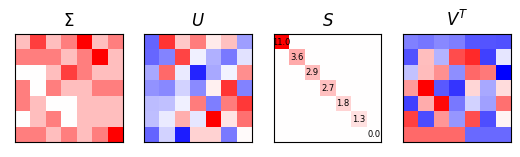

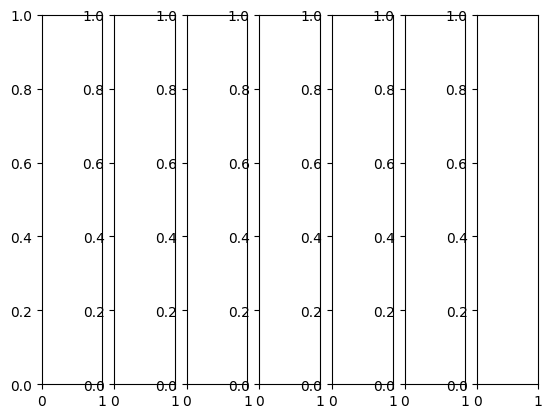

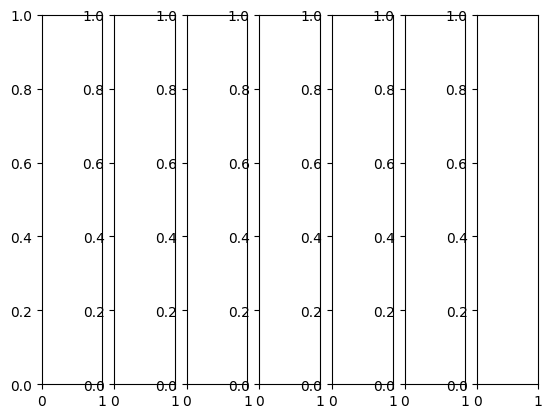

In [9]:
cat=True
y = feature_tensor
x = label_tensor
if cat:
    x = torch.cat((x, context_tensor), dim=1)
sigma = (y.T @ x )

U, S_, V = torch.svd(sigma)
print(S_)

n_val = len(S_)

fig, axes = plt.subplots(1, 4, dpi=100)

sigma = sigma.detach().numpy()
U = U.detach().numpy()
S = torch.diag(S_).detach().numpy()
V = V.detach().numpy()

axes[0].imshow(sigma, cmap='bwr', vmin=-np.max(sigma))
axes[0].title.set_text(r'$\Sigma$')
axes[1].imshow(U, cmap='bwr', vmin=-np.max(U))
axes[1].title.set_text(r'$U$')
axes[2].imshow(S, cmap='bwr', vmin=-np.max(S), vmax=np.max(S))
axes[2].title.set_text(r'$S$')
axes[3].imshow(V.T, cmap='bwr', vmin=-np.max(V))
axes[3].title.set_text(r'$V^T$')
for (j,i), label in np.ndenumerate(S):
    if label != 0:
        axes[2].text(i,j, ("%.1f" % label),ha='center',va='center', fontsize=6)

for ax in axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


fig1, axes1 = plt.subplots(1, n_val)
fig2, axes2 = plt.subplots(1, n_val)
mat_sum = np.zeros_like(np.outer(U[:,0], V[:,0]))
output_sum = np.zeros(feature_tensor.T.shape, dtype=np.float)
print(output_sum.shape)
for i in range(n_val):
    mat = np.outer(U[:,i], V[:,i])
    mat_sum += S_[i].numpy() * mat
    print(mat.shape, x.T.shape)
    output = mat @ x.numpy().T
    output_sum += output
    axes1[i].imshow(mat_sum)
    axes2[i].imshow(output_sum)
    axes1[i].xaxis.set_visible(False)
    axes1[i].yaxis.set_visible(False)
    axes2[i].xaxis.set_visible(False)
    axes2[i].yaxis.set_visible(False)

In [ ]:
y_split = torch.split(feature_tensor, 4, dim=0)
x = label_tensor
cat=True
if cat == True:
    x = torch.cat((label_tensor, context_tensor), dim=1)
    x_fake = torch.cat((label_tensor, torch.zeros_like(context_tensor)), dim=1)
else:
    x_fake = label_tensor

x_split = torch.split(x, 4, dim=0)

mainlist = [i for i in range(len(y_split))]
y_split = [torch.cat([y_split[comb] for comb in combs], dim=0) for combs in it.combinations(mainlist, dim_context-1)]
x_split = [torch.cat([x_split[comb] for comb in combs], dim=0) for combs in it.combinations(mainlist, dim_context-1)]
print([_.shape for _ in y_split])
sigmas = [(y.T @ x) for y,x in zip(y_split, x_split)]

k = 0
U, S_, V = torch.svd(sigmas[k])
print(S_)
n_val = len(S_)

fig, axes = plt.subplots(1,4)

sigma = sigmas[k].detach().numpy()
U = U.detach().numpy()
S = torch.diag(S_).detach().numpy()
V = V.detach().numpy()

im = axes[0].imshow(sigma, cmap='bwr', vmin=-np.max(sigma))
plt.colorbar(im)
axes[0].title.set_text(r'$\Sigma$')
axes[1].imshow(U, cmap='bwr', vmin=-np.max(U))
axes[1].title.set_text(r'$U$')
axes[2].imshow(S, cmap='bwr', vmin=-np.max(S), vmax=np.max(S))
axes[2].title.set_text(r'$S$')
axes[3].imshow(V.T, cmap='bwr', vmin=-np.max(V))
axes[3].title.set_text(r'$V^T$')
for (j,i), label in np.ndenumerate(S):
    if label != 0:
        axes[2].text(i,j, ("%.1f" % label),ha='center',va='center', fontsize=6)

for ax in axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

fig1, axes1 = plt.subplots(1, n_val)
fig2, axes2 = plt.subplots(1, n_val)
mat_sum = np.zeros_like(np.outer(U[:,0], V[:,0]))
output_sum = np.zeros(feature_tensor.T.shape, dtype=np.float)
print(output_sum.shape)
for i in range(n_val):
    mat = np.outer(U[:,i], V[:,i])
    mat_sum += S_[i].numpy() * mat
    print(mat.shape, x.T.shape)
    output = mat @ x.numpy().T
    output_sum += output
    axes1[i].imshow(mat_sum)
    axes2[i].imshow(output_sum)
    axes1[i].xaxis.set_visible(False)
    axes1[i].yaxis.set_visible(False)
    axes2[i].xaxis.set_visible(False)
    axes2[i].yaxis.set_visible(False)

In [ ]:
# plt.imshow((mat_sum - mat_sum2).T)

In [ ]:
cat = True
cat_fake = True
average = False
divide_sigma_xx = False

if not separate_contexts:
    n_val = dim_input if not cat else dim_features_per_context
else:
    n_val = dim_input if not cat else dim_input + dim_context

y_split = torch.split(feature_tensor, dim_input, dim=0)
x = label_tensor

if cat == True:
    x = torch.cat((label_tensor, context_tensor), dim=1)
    x_fake = torch.cat((label_tensor, torch.zeros_like(context_tensor)), dim=1)
else:
    x_fake = label_tensor

x_split = torch.split(x, dim_input, dim=0)
x_split_fake = torch.split(x_fake, dim_input, dim=0)

mainlist = [i for i in range(len(y_split))]

from math import comb
n_col = sum([comb(dim_context, k) for k in range(dim_context)]) if not average else dim_context
S_all = torch.zeros((n_val, n_col))
U_all = torch.zeros((n_col, dim_output, dim_input+dim_context if cat else dim_input))
V_all = torch.zeros((n_col, dim_input + dim_context if cat else dim_input, dim_input+dim_context if cat else dim_input))
sigmas_all = torch.zeros((n_col, dim_output, dim_input + dim_context if cat else dim_input))
i = 0

for c in range(1, dim_context+1):
    if c == dim_context:
        x_comb = [torch.cat([x_split[comb] for comb in combs], dim=0) for combs in it.combinations(mainlist, c)]
    else:
        if not cat_fake:
            x_comb = [torch.cat([x_split[comb] for comb in combs], dim=0) for combs in it.combinations(mainlist, c)]
        else:
            x_comb = [torch.cat([x_split_fake[comb] for comb in combs], dim=0) for combs in it.combinations(mainlist, c)]

    y_comb = [torch.cat([y_split[comb] for comb in combs], dim=0) for combs in it.combinations(mainlist, c)]

    sigmas = [(y.T @ x) for y,x in zip(y_comb, x_comb)]
    sigmas_xx = [x.T @ x for x in x_comb]
    
    S_av = torch.zeros(n_val)
    for sig, sig_x in zip(sigmas, sigmas_xx):
        U, S, V = torch.svd(sig)

        if divide_sigma_xx:
            _, S_x, _ = torch.svd(sig_x)
            
            print(S_x)
            S = S / S_x

        S_av += S
#         for i in range(n_val):
#             mat = np.outer(U[:,i], V[:,i])
#             mat_sum2 += S_[i].numpy() * mat
#             axes[i].imshow(mat_sum2)
        if not average:
            S_all[:, i] = S
            U_all[i, :, :] = U
            V_all[i, :, :] = V
            sigmas_all[i, :, :] = sig
            
        i += 1

    if average:
        S_all[:, c-1] = S_av/len(sigmas)

# print(S_all.numpy())
fig, ax = plt.subplots(1)
ax.imshow(S_all.detach().numpy(), cmap='bwr')
if average:
    labels = [r'$\Sigma^{' + '{}'.format(i) + '}_{av}$' for i in range(1, dim_context+1)]
    ticks = np.arange(0, len(labels))
    xlabel = r'(Average) singular values for covariance' + '\n' + r'across $n$ contexts, $\Sigma^{n}_{av}$'
else:
    all_combs = [[comb for comb in it.combinations(mainlist, c)] for c in range(1, dim_context+1)]
    all_combs = list(it.chain.from_iterable(all_combs))
    all_combs = [''.join([str(c) for c in comb]) for comb in all_combs]
    labels = [r'$\Sigma^{' + '{}'.format(comb) + '}$' for comb in all_combs]
    ticks = np.arange(0, len(labels))
    xlabel = r'Singular values across all contextual' +'\n' + r'permutations of cov matrix, $\Sigma$'

print(labels)
ax.set_xticks(ticks=ticks, labels=labels)
ax.xaxis.tick_top()
ax.set_xlabel(xlabel, fontsize=10)
ax.xaxis.set_label_position('top') 
for (j,i), label in np.ndenumerate(S_all):
    ax.text(i,j, ("%.1f" % label),ha='center',va='center', fontsize=8)

In [ ]:
all_combs = [[comb for comb in it.combinations(mainlist, c)] for c in range(1, dim_context+1)]
all_combs = list(it.chain.from_iterable(all_combs))
all_titles = [''.join([str(i) for i in comb]) for comb in all_combs]
all_titles = [r'$\Sigma^{' + '{}'.format(i) + '}$' for i in all_titles]

for comb, sig, U_, S_, V_ in zip(all_combs, sigmas_all, U_all, S_all.T, V_all):
    fig, axes = plt.subplots(1,4)
    print(torch.max(U_), torch.max(V_))
    print(torch.min(U_), torch.min(V_))
    lim = np.maximum(np.abs(np.min(sig.numpy())), np.max(sig.numpy()))
    im = axes[0].imshow(sig.numpy(), cmap='bwr', vmin=-lim, vmax=lim)
    plt.colorbar(im)
    axes[0].title.set_text(r'$\Sigma$')
    lim = np.maximum(np.abs(np.min(U_.numpy())), np.max(U_.numpy()))
    axes[1].imshow(U_.numpy(), cmap='bwr', vmin=-lim, vmax=lim)
    axes[1].title.set_text(r'$U$')
    lim = np.maximum(np.abs(np.min(S_.numpy())), np.max(S_.numpy()))
    axes[2].imshow(torch.diag(S_).numpy(), cmap='bwr', vmin=-lim, vmax=lim)
    axes[2].title.set_text(r'$S$')
    lim = np.maximum(np.abs(np.min(V_.numpy())), np.max(V_.numpy()))
    axes[3].imshow(V_.T.numpy(), cmap='bwr', vmin=-lim, vmax=lim)
    axes[3].title.set_text(r'$V^T$')
    for (j,i), label in np.ndenumerate(torch.diag(S_).numpy()):
        if label != 0:
            axes[2].text(i,j, ("%.1f" % label),ha='center',va='center', fontsize=6)
            
    title = ''.join([str(i) for i in comb])
    fig.suptitle(r'$\Sigma^{' + '{}'.format(title) + '}$', fontsize=14)
        
    fig2, axes2 = plt.subplots(1, len(S_))
    for ax, U_col, V_col in zip(axes2, U_.T, V_.T):
        outer = torch.outer(U_col, V_col).numpy()
        contrib = outer @ x.T.numpy()
        ax.imshow(contrib)
        
    for ax in list(axes) + list(axes2):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
    fig.savefig(title + '.png', format='png')

In [ ]:
top = 4
subtractive_pathways = True

if top != 4:
    raise NotImplementedError()
offset = S_all.shape[-1] - top
S_top = S_all[:,-top:]
idx_flatten = torch.topk(S_top.flatten(), k=top*S_all.shape[-2])[1]
print(idx_flatten)
idx = np.array([[i.numpy()//top, i.numpy()%top] for i in idx_flatten])
outer_sum = torch.zeros((dim_output, dim_input if not cat else dim_input + dim_context))

for k, idx_k in enumerate(idx):
    S_ = S_top[idx_k[0], idx_k[1]]
    U_ = U_all[offset+idx_k[1], :, idx_k[0]]
    V_ = V_all[offset+idx_k[1], :, idx_k[0]]
    plt.figure()
    vmax = np.max(U_all[idx_k[1],:,:].numpy())
    vmin = -vmax
    fig, axes = plt.subplots(1,6)
    axes[0].imshow(U_.numpy()[:,np.newaxis], cmap='bwr', vmin=vmin, vmax=vmax)
    axes[0].title.set_text(r'$U$')
    
    vmax = np.max(V_all[idx_k[1],:,:].numpy())
    vmin = -vmax
    axes[1].imshow(V_.T.numpy()[:,np.newaxis], cmap='bwr', vmin=vmin, vmax=vmax)
    axes[1].title.set_text(r'$V^T$')
    
    outer = torch.outer(U_, V_)
    axes[2].imshow(outer.numpy())
    axes[2].title.set_text(r'$sUV^T$')
    
    if (idx_k[1] + offset) in [3,4,5] and subtractive_pathways:
        outer_sum -= S_ * outer
    else:
        outer_sum += S_ * outer
    axes[3].imshow(outer_sum.numpy())
    axes[3].title.set_text('cumulative\n' + r'$sUV^T$')
    
    contrib = S_ * outer.numpy() @ x.numpy().T
    axes[4].imshow(contrib)
    axes[4].title.set_text('Contrib\nto pred')
    
    pred = S_ * outer_sum.numpy() @ x.numpy().T
    axes[5].imshow(pred)
    axes[5].title.set_text('Cumulative\npred')
    
#     title = str(k) + '-th val, mode: ' + str(idx_k[0]) + ', sigma pathway: ' + str(idx_k[1]+offset) + ', s val: ' + ("%.1f" % S_.numpy())
    title = str(k) + '-th val, ' + all_titles[idx_k[1]+offset] + ', s=' + ("%.1f" % S_.numpy()) + ', mode=' + str(idx_k[0])
    fig.suptitle(title)
        
    for ax in axes:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_fontsize(8)

# print(idx)

## Train gated network

In [ ]:
# Training
lr = .001  # Learning rate
gamma = 1e-12 * 10**7 if len(pathways) > 3 else 1e-4
n_epochs = 10000

In [ ]:
multi_pathway_model = GLNNet(dims=dims_gated, pathways=pathways, context_to_pathway_map=mapping, 
                             n_context=dim_context, context_in_input=True)
print(isinstance(multi_pathway_model, GLNNet))

SEED = 2021
mu.set_seed(seed=SEED)

mu.initializer_(multi_pathway_model, gamma)

losses_gated, preds_gated, rsms_gated, pathway_preds_gated, svds, weights_gated = train(multi_pathway_model,
                  label_tensor_,
                  feature_tensor,
                  context_tensor,
                  n_epochs=n_epochs,
                  lr=lr,
                  hold_out_i=held_out,
                  corr=False,
                  rsm_interval=n_epochs//100)

## Final gated network weights

In [ ]:
svds_final_transpose = [[svds[0][i][-1,:,:], svds[1][i][-1,:], svds[2][i][-1,:,:]] for i in range(len(svds[0]))]
weights_final = [w[-1,:,:] for w in weights_gated]

for k, (svd, weight) in enumerate(zip(svds_final_transpose, weights_final)):
    U, S, V = svd
    S = np.diag(S)
#     weight = weight.numpy()
#     U, S, V, weight = U.numpy(), np.diag(S.numpy()), V.numpy(), weight.numpy()
    fig, axes = plt.subplots(1,4)

    lim = np.maximum(np.abs(np.min(weight)), np.max(weight))
    im = axes[0].imshow(weight, cmap='bwr', vmin=-lim, vmax=lim)
    plt.colorbar(im)
    axes[0].title.set_text(r'$W$')

    lim = np.maximum(np.abs(np.min(U)), np.max(U))
    axes[1].imshow(U, cmap='bwr', vmin=-lim, vmax=lim)
    axes[1].title.set_text(r'$U$')
                     
    lim = np.maximum(np.abs(np.min(S)), np.max(S))
    axes[2].imshow(S, cmap='bwr', vmin=-lim, vmax=lim)
    axes[2].title.set_text(r'$S$')
                     
    lim = np.maximum(np.abs(np.min(V)), np.max(V))
    axes[3].imshow(V.T, cmap='bwr', vmin=-lim, vmax=lim)
    axes[3].title.set_text(r'$V^T$')
    for (j,i), label in np.ndenumerate(S):
        if label != 0:
            axes[2].text(i,j, ("%.1f" % label),ha='center',va='center', fontsize=6)
            
#     title = ''.join([str(i) for i in comb])
#     fig.suptitle(r'$\Sigma^{' + '{}'.format(title) + '}$', fontsize=14)
        
#     fig2, axes2 = plt.subplots(1, len(S_))
#     for ax, U_col, V_col in zip(axes2, U_.T, V_.T):
#         outer = torch.outer(U_col, V_col).numpy()
#         contrib = outer @ x.T.numpy()
#         ax.imshow(contrib)
        
    for ax in list(axes):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
    plt.tight_layout()
    fig.savefig('weights_' + str(k) + '.png', format='png')
    
plt.figure()
sum_W = weights_final[0] + np.pad(weights_final[1], ((0,0),(3,0))) + np.pad(weights_final[2], ((0,0),(3,0)))
plt.imshow(sum_W)
plt.figure()
plt.imshow(sum_W @ torch.cat((context_tensor, label_tensor),dim=1).T.numpy())

In [ ]:
# plt.imshow((weights_final[0][:,3:] + np.cweights_final[1]+ weights_final[2]) @ label_tensor.numpy().T)

In [ ]:
# contribs = []
# for i, W in enumerate(weights_final[0:4]):
#     if i == 0:
#         mult = torch.cat((context_tensor, label_tensor), dim=1).T
#     elif i == 1:
#         mult = torch.cat((label_tensor[:8,:], torch.zeros(4,4)), dim=0).T
#     elif i == 2:
#         mult = torch.cat((label_tensor[:4,:], torch.zeros(4,4), label_tensor[8:,:]), dim=0).T
#     elif i == 3:
#         mult = torch.cat((torch.zeros(4,4), label_tensor[4:,:]), dim=0).T

#     contrib = torch.Tensor(W) @ mult
#     contribs.append(contrib.numpy())
#     plt.figure()
#     im=plt.imshow(contrib.numpy())
#     plt.colorbar(im)
    
# sum_contribs = sum(contribs)
# plt.figure()
# im = plt.imshow(sum_contribs)
# plt.colorbar(im)
# # contribs = [W @ torch.cat((context_tensor, label_tensor), dim=1).numpy() if i==0 else x.T for W in weight_mats]
# # for c in contribs:
# #     plt.figure()
# #     plt.imshow(c)

In [ ]:
plt.rcParams['animation.ffmpeg_path'] = '/Users/jo/miniforge3/envs/gated/bin/ffmpeg'
pathway_preds = multi_pathway_model.compute_pathway_preds(label_tensor_, context_tensor)
pathway_preds_np = pathway_preds.detach().numpy()

additional_data = {'weights': weights_gated, 'U': svds[0], 'S':svds[1], 'V':svds[2]}

pf.animate_pathway_preds(pathway_preds_gated, dim_context, additional_data_dict=additional_data,
                         plot_specs=plot_specs, data_interval=n_epochs//100)

## Train ReLU network

In [ ]:
from ReluNNet import ReluNNet

relunn_model = ReluNNet(dims=dims_relu, n_context=dim_context, gateable_layers=gateable_layers, final_relu=False)

In [ ]:
# Training
SEED = 2021
mu.set_seed(seed=SEED)
gamma = 1e-12
lr = 0.0001
n_epochs= 250000
mu.initializer_(relunn_model, gamma)

losses_relu, preds_relu, rsms_relu, _, _, _ = train(relunn_model,
                  label_tensor,
                  feature_tensor,
                  context_tensor,
                  n_epochs=n_epochs,
                  lr=lr,
                  hold_out_i=held_out,
                  corr=False,
                  rsm_interval=n_epochs//100,
                  relu=True)

In [ ]:
plt.figure()
plt.plot(losses_relu, 'r', label='relu')
# plt.plot(losses_gated, 'b', label='gated')
plt.legend()
# plt.xlim([60000,90000])
plt.show()

In [ ]:
predictions = preds_gated[-1,:,:]
targets = feature_tensor.detach().numpy()

pf.plot_preds_targets(predictions, targets, separate_contexts, dim_context+1, plot_specs)

In [ ]:
predictions = preds_relu[-1,:,:]
targets = feature_tensor.detach().numpy()

pf.plot_preds_targets(predictions, targets, separate_contexts, dim_context+1, plot_specs)

In [ ]:
for c in range(dim_context-1, dim_context+1):
    print([combs for combs in it.combinations(mainlist, c)])

In [ ]:
combs = it.combinations(mainlist, 2)

masks = []
for comb in combs:
    mask = np.zeros((12,28))
    for band in comb:
        mask[band*dim_input:(band+1)*dim_input] = 1
    masks.append(mask)

In [ ]:
# x = torch.cat((context_tensor, label_tensor), dim=1)
# sigma = (feature_tensor.T @ x)
# sigma[14:,:] = 0
# sigma /= torch.max(sigma)
# x[4:,:] = 0
# out = (sigma @ x.T).numpy()
# im = plt.imshow(out)
# plt.colorbar(im)
# print(torch.max(sigma))

In [ ]:
x_all = torch.cat((context_tensor, label_tensor), dim=1)
x_1 = torch.cat((torch.zeros_like(context_tensor), label_tensor), dim=1)
x_1[dim_input:,:] = 0
# x_[dim_input:,:] = 0
# print(feature_tensor.shape, x_.shape)
# i = 4
# sigma_ = torch.outer(feature_tensor[i,:], x_[i,:])
# plt.imshow(sigma_.numpy())
sigma_all = feature_tensor.T @ x_all / 12
sigma_1 = feature_tensor.T @ x_1 / 12

fig, axes = plt.subplots(1,3)
im=axes[0].imshow(sigma_all.numpy())
plt.colorbar(im)
im=axes[1].imshow(sigma_1.numpy())
plt.colorbar(im)
sigma_all_resid = sigma_all - sigma_1
im=axes[2].imshow(sigma_all_resid.numpy())
plt.colorbar(im)

sigma_lim = np.maximum(np.abs(np.min(sigma_all.numpy())), np.max(sigma_all.numpy()))
show_svd(sigma_all_resid, sigma_lim)

# sigma[2*dim_features_per_context:, :] = 0
# sigma[:, :dim_context] = 0
# sigma[:, dim_context:] += 0.5
# sigma = sigma / torch.max(sigma)
out = sigma @ x_.T

# sigma = sigma.numpy()
# x_ = x_.numpy()
# out = out.numpy()

# im=axes[0].imshow(x_)
# lim = np.maximum(np.abs(np.min(sigma)), np.max(sigma))
# im=axes[1].imshow(sigma, cmap='bwr', vmin=-lim, vmax=lim)
# plt.colorbar(im)
# lim = np.maximum(np.abs(np.min(out)), np.max(out))
# im=axes[2].imshow(out, cmap='bwr', vmin=-lim, vmax=lim)
# plt.colorbar(im)

In [ ]:
cat = True
subtract_sigma_explained = True
directions = [-1,-1,-1,1]

if not separate_contexts:
    n_val = dim_input if not cat else dim_features_per_context
else:
    n_val = dim_input if not cat else dim_input + dim_context

y_split = torch.split(feature_tensor, dim_input, dim=0)
x = label_tensor

if cat == True:
    x = torch.cat((context_tensor, label_tensor), dim=1)
    x_fake = torch.cat((torch.zeros_like(context_tensor), label_tensor), dim=1)
else:
    x_fake = label_tensor

x_split = torch.split(x, dim_input, dim=0)
x_split_fake = torch.split(x_fake, dim_input, dim=0)

# mainlist = [i for i in range(len(y_split))]
mainlist = [i for i in range(1, len(y_split)+1)]
print(mainlist)

S_all = torch.zeros((n_val, dim_context))
sigma_explained = torch.zeros(feature_tensor.shape[1], n_val)
output_explained = torch.zeros_like(feature_tensor.T)
sing_vals = [0,0,0,0,0,0,0]

sigma = feature_tensor.T @ x

# sigma_explained = sigma.clone()
# sigma_explained[2*dim_features_per_context:, :] = 0

for i in range(20):
    S_max = 0
    i = 0
#     sing_vals = []
    fig, axes = plt.subplots(1,4, figsize=(8,3))
    fig.suptitle('preds')
    fig2, axes2 = plt.subplots(2,4, figsize=(8,6))
    fig2.suptitle('sigmas')
#     fig3, axes3 = plt.subplots(1)
#     im = axes3.imshow(sigma_explained)
#     plt.colorbar(im)

    for c in range(dim_context-1, dim_context+1):
#         print(c)
#         if c == dim_context:
#             x_comb = [torch.cat([x_split[comb] for comb in combs], dim=0) for combs in it.combinations(mainlist, c)]
#         else:
#             x_comb = [torch.cat([x_split_fake[comb] for comb in combs], dim=0) for combs in it.combinations(mainlist, c)]

#         y_comb = [torch.cat([y_split[comb] for comb in combs], dim=0) for combs in it.combinations(mainlist, c)]

#         sigmas = [(y.T @ x)/y.shape[0] for y,x in zip(y_comb, x_comb)]  
#         sigmas = [s / torch.max(s) for s in sigmas]

        masks = []
#         combs = it.combinations(mainlist, c)
        combs = [[1,2], [1,3]] if c!= dim_context else [[1,2,3]]
        sigmas = [sigma for _ in range(4)]
        for comb in combs:
            mask = torch.zeros_like(sigma)
            mask[:dim_features_per_context,:] = 1
            for band in comb:
                mask[band*dim_features_per_context:(band+1)*dim_features_per_context, :] = 1
#             if c != dim_context:
#                 mask[:,:dim_context] = 0
            masks.append(mask)
            
        sigmas = [m*s for m, s in zip(masks, sigmas)]
        sigmas = [s / torch.max(s) for s in sigmas]

        if subtract_sigma_explained:
            sigmas_residual = [s - sigma_explained for s in sigmas]
        else:
            sigmas_residual = sigmas
            
        print('sig:', len(sigmas), 'resid', len(sigmas_residual))  
        for sig, sig_resid in zip(sigmas, sigmas_residual):
            U, S, V = torch.svd(sig_resid)
            princ_sing_val = max(S.detach().numpy())

            im = axes[i].imshow(princ_sing_val * np.outer(U.numpy()[:,0], V.numpy()[:,0]) @ x.T.numpy())
            plt.colorbar(im)
            axes[i].xaxis.set_visible(False)
            axes[i].yaxis.set_visible(False)
            axes[i].title.set_text(r'$\Sigma^{yx} = $' + '%.3f' % princ_sing_val)
            axes[i].xaxis.set_visible(False)
            axes[i].yaxis.set_visible(False)

            sing_vals[i] = princ_sing_val
            
            im = axes2[0,i].imshow(sig.numpy())
            plt.colorbar(im)
            im = axes2[1,i].imshow(sig_resid.numpy())
            plt.colorbar(im)
            
            axes2[0,i].xaxis.set_visible(False)
            axes2[0,i].yaxis.set_visible(False)

            if princ_sing_val > S_max:
                S_max = princ_sing_val
                U_max = U[:,0]
                V_max = V[:,0]
                winner = i
            i += 1
    
    plt.tight_layout()

#         S_all[:, c-1] = S_av/len(sigmas)
#     print(S_max)
#     print(sing_vals)
    
    component = princ_sing_val * torch.outer(U_max, V_max)
    output_explained += component @ x.T
    sigma_explained += output_explained @ x
    plt.figure()
    im=plt.imshow(sigma_explained.numpy())
    plt.colorbar(im)
    
#     for ax, sig_ in zip(axes2[1,:], sigmas):
# #         print(len(sigmas), len(axes2[1,:]))
#         ax.imshow(sig_.numpy())
        
    fig, axes = plt.subplots(1,2)
    im = axes[0].imshow(component.numpy() @ x.T.numpy())
    plt.colorbar(im)
    im = axes[1].imshow(output_explained.numpy())
    plt.colorbar(im)
    axes[0].xaxis.set_visible(False)
    axes[0].yaxis.set_visible(False)
    axes[0].title.set_text('Component to add')
    axes[1].xaxis.set_visible(False)
    axes[1].yaxis.set_visible(False)
    axes[1].title.set_text('Cumulative sum')

#     y_split = torch.split(feature_tensor - , dim_input, dim=0)

print(sing_vals)
# print(S_all.numpy())
fig, ax = plt.subplots(1)
ax.imshow(S_all.detach().numpy(), cmap='bwr')
# labels = [r'$\Sigma^{' + '{}'.format(''.join([str(j) for j in range(1,i)])) + '}_{av}$' for i in range(2, dim_context+2)]
labels = [r'$\Sigma^{' + '{}'.format(i) + '}_{av}$' for i in range(1, dim_context+1)]
print(labels)
ax.set_xticks(ticks=np.arange(0,dim_context), labels=labels)
ax.xaxis.tick_top()
ax.set_xlabel(r'(Average) singular values for covariance' + '\n' + r'across $n$ contexts, $\Sigma^{n}_{av}$', fontsize=10)
ax.xaxis.set_label_position('top') 
for (j,i), label in np.ndenumerate(S_all):
    ax.text(i,j, ("%.1f" % label),ha='center',va='center', fontsize=8)

In [ ]:
x_with_ctx = torch.cat((context_tensor, label_tensor), dim=1)
x_without_ctx = label_tensor
# x_without_ctx = x_with_ctx.clone()

x_with_ctx_split = torch.split(x_with_ctx, dim_input, dim=0)
x_without_ctx_split = torch.split(x_without_ctx, dim_input, dim=0)

mainlist = [i for i in range(0,dim_context)]
combs = it.combinations(mainlist, 2)

x_with_ctx_concat = [torch.cat([x_with_ctx_split[c] for c in comb], dim=0) for comb in it.combinations(mainlist, 2)]
x_without_ctx_concat = [torch.cat([x_without_ctx_split[c] for c in comb], dim=0) for comb in it.combinations(mainlist, 2)]

all_combs = [[comb for comb in it.combinations(mainlist, c)] for c in range(2, dim_context+1)]
all_combs = list(it.chain.from_iterable(all_combs))

x_list = [torch.cat([x_with_ctx_split[i] if i in comb else torch.zeros_like(x_with_ctx_split[i]) 
          for i in range(3)], dim=0) 
          for comb in it.combinations(mainlist, 2)]
x_list.append(x_with_ctx)

y_split = torch.split(feature_tensor, dim_input, dim=0)
y_concat = [torch.cat([y_split[c] for c in comb]) for comb in it.combinations(mainlist, 2)]

sigmas_double = [y_.T @ x_ for x_, y_ in zip(x_without_ctx_concat, y_concat)]
sigmas_triple = [feature_tensor.T @ x_with_ctx]

sigmas_all = sigmas_double + sigmas_triple

title_list = [1,2,3]
all_combs = [[comb for comb in it.combinations(title_list, c)] for c in range(2, dim_context+1)]
all_combs = list(it.chain.from_iterable(all_combs))
all_titles = [''.join([str(i) for i in comb]) for comb in all_combs]
all_titles = [r'$\Sigma^{' + '{}'.format(i) + '}$' for i in all_titles]

y_sum = torch.zeros_like(feature_tensor).T
for j in range(40):
    fig, axes = plt.subplots(1, len(sigmas_all)+3, layout='constrained', figsize=(8,14))
#     fig.suptitle(j)
#     for i, sig in enumerate(sigmas_all):
#     lim = np.maximum(np.abs(np.min(sig.numpy())), np.max(sig.numpy()))
#     show_svd(sig, lim)
#     plt.tight_layout()
    
    s_max = 0
    for i, sig in enumerate(sigmas_all):
        U, S, V = torch.svd(sig)
        
        lim = np.maximum(np.abs(np.min(sig.numpy())), np.max(sig.numpy()))
        im=axes[i].imshow(sig.numpy(), cmap='bwr', vmin=-lim, vmax=lim)
        plt.colorbar(im)
        axes[i].xaxis.set_visible(False)
        axes[i].yaxis.set_visible(False)
        axes[i].title.set_text(all_titles[i] + ", %.1f" % np.max(S.numpy()))
        
        if torch.max(S) >= s_max:
            s_max = torch.max(S)
            U_max = U[:,0]
            V_max = V[:,0]
            winner = i
    
    axes[winner].title.set_text(all_titles[i] + ", %.1f" % s_max + '*')

    sigma_contrib = s_max * torch.outer(U_max, V_max)
    if sigma_contrib.shape[1] != dim_input + dim_context:
        sigma_contrib = torch.cat((torch.zeros(sigma_contrib.shape[0], dim_context), sigma_contrib), dim=1)
    im=axes[-3].imshow(sigma_contrib.numpy())
    axes[-3].title.set_text(r'$\Sigma$ contrib')
    axes[-3].xaxis.set_visible(False)
    axes[-3].yaxis.set_visible(False)
    plt.colorbar(im)

    if j==0:
        div = 7
    elif j==1:
        div = 3
    elif j in [2,3]:
        div = 4
    elif j in [4,5]:
        div = 3
#     elif j==4:
#         div = 3
    else:
        div = 4
        
    y_contrib = (1/div) * sigma_contrib @ x_list[winner].T
    y_sum += y_contrib
    im=axes[-2].imshow(y_contrib.numpy())
    axes[-2].title.set_text(r'$y$ contrib')
    axes[-2].xaxis.set_visible(False)
    axes[-2].yaxis.set_visible(False)
    plt.colorbar(im)
    
    lim = np.maximum(np.abs(np.min(y_sum.numpy())), np.max(y_sum.numpy()))
    im = axes[-1].imshow(y_sum.numpy(), vmin=-lim, vmax=lim)
    axes[-1].title.set_text(r'$y$')
    axes[-1].xaxis.set_visible(False)
    axes[-1].yaxis.set_visible(False)
    plt.colorbar(im)
    
    y_contrib_split = torch.split(y_contrib, dim_input, dim=1)
    y_contrib_concat = [torch.cat([y_contrib_split[c] for c in comb], dim=1) for comb in it.combinations(mainlist, 2)]
    sigmas_double_explained = [y_ @ x_ for x_, y_ in zip(x_without_ctx_concat, y_contrib_concat)]
    sigmas_triple_explained = [y_contrib @ x_with_ctx]
    sigmas_explained = sigmas_double_explained + sigmas_triple_explained
    
    sigmas_all = [s - s_explained for s, s_explained in zip(sigmas_all, sigmas_explained)]
#     sigmas_triple = [feature_tensor.T @ x_with_ctx]

In [ ]:
x_with_ctx = torch.cat((context_tensor, label_tensor), dim=1)
x_without_ctx = label_tensor
# x_without_ctx = x_with_ctx.clone()

x_with_ctx_split = torch.split(x_with_ctx, dim_input, dim=0)
x_without_ctx_split = torch.split(x_without_ctx, dim_input, dim=0)

mainlist = [i for i in range(0,dim_context)]
combs = it.combinations(mainlist, 2)

x_with_ctx_concat = [torch.cat([x_with_ctx_split[c] for c in comb], dim=0) for comb in it.combinations(mainlist, 2)]
x_without_ctx_concat = [torch.cat([x_without_ctx_split[c] for c in comb], dim=0) for comb in it.combinations(mainlist, 2)]

all_combs = [[comb for comb in it.combinations(mainlist, c)] for c in range(2, dim_context+1)]
all_combs = list(it.chain.from_iterable(all_combs))

x_list = [torch.cat([x_with_ctx_split[i] if i in comb else torch.zeros_like(x_with_ctx_split[i]) 
          for i in range(3)], dim=0) 
          for comb in it.combinations(mainlist, 2)]
x_list.append(x_with_ctx)
x_list = [val for val in x_list for _ in (0, 1)]

y_split = torch.split(feature_tensor, dim_input, dim=0)
y_concat = [torch.cat([y_split[c] for c in comb]) for comb in it.combinations(mainlist, 2)]

sigmas_double_without = [y_.T @ x_ for x_, y_ in zip(x_without_ctx_concat, y_concat)]
sigmas_double_with = [y_.T @ x_ for x_, y_ in zip(x_with_ctx_concat, y_concat)]
sigmas_triple_with = [feature_tensor.T @ x_with_ctx]
sigmas_triple_without = [feature_tensor.T @ x_without_ctx]

sigmas_all = sigmas_double_without + sigmas_double_with + sigmas_triple_without + sigmas_triple_with

title_list = [1,2,3]
all_combs = [[comb for comb in it.combinations(title_list, c)] for c in range(2, dim_context+1)]
all_combs = list(it.chain.from_iterable(all_combs))
all_titles = [''.join([str(i) for i in comb]) for comb in all_combs]
all_titles = [r'$\Sigma^{' + '{}'.format(i) + '}$' for i in all_titles]

y_sum = torch.zeros_like(feature_tensor).T
for j in range(40):
    fig, axes = plt.subplots(1, len(sigmas_all)+3, layout='constrained', figsize=(8,14))
#     fig.suptitle(j)
#     for i, sig in enumerate(sigmas_all):
#     lim = np.maximum(np.abs(np.min(sig.numpy())), np.max(sig.numpy()))
#     show_svd(sig, lim)
#     plt.tight_layout()
    
    s_max = 0
    for i, sig in enumerate(sigmas_all):
        U, S, V = torch.svd(sig)
        
        lim = np.maximum(np.abs(np.min(sig.numpy())), np.max(sig.numpy()))
        im=axes[i].imshow(sig.numpy(), cmap='bwr', vmin=-lim, vmax=lim)
        plt.colorbar(im)
        axes[i].xaxis.set_visible(False)
        axes[i].yaxis.set_visible(False)
        title = "%.1f" % np.max(S.numpy())
        axes[i].title.set_text(title)
#         axes[i].title.set_text(all_titles[i] + ", %.1f" % np.max(S.numpy()))
        
        if torch.max(S) > s_max:
            s_max = torch.max(S)
            U_max = U[:,0]
            V_max = V[:,0]
            winner = i
            
    title = "%.1f" % s_max + '*'
    axes[winner].title.set_text(title)

    sigma_contrib = s_max * torch.outer(U_max, V_max)
    if sigma_contrib.shape[1] != dim_input + dim_context:
        sigma_contrib = torch.cat((torch.zeros(sigma_contrib.shape[0], dim_context), sigma_contrib), dim=1)
    im=axes[-3].imshow(sigma_contrib.numpy())
    axes[-3].title.set_text(r'$\Sigma$ contrib')
    axes[-3].xaxis.set_visible(False)
    axes[-3].yaxis.set_visible(False)
    plt.colorbar(im)

    if j==0:
        div = 7
    elif j==1:
        div = 3
    elif j in [2,3]:
        div = 4
    elif j in [4,5]:
        div = 3
#     elif j==4:
#         div = 3
    else:
        div = 4
        
    y_contrib = (1/div) * sigma_contrib @ x_list[winner].T
    y_sum += y_contrib
    im=axes[-2].imshow(y_contrib.numpy())
    axes[-2].title.set_text(r'$y$ contrib')
    axes[-2].xaxis.set_visible(False)
    axes[-2].yaxis.set_visible(False)
    plt.colorbar(im)
    
    lim = np.maximum(np.abs(np.min(y_sum.numpy())), np.max(y_sum.numpy()))
    im = axes[-1].imshow(y_sum.numpy(), vmin=-lim, vmax=lim)
    axes[-1].title.set_text(r'$y$')
    axes[-1].xaxis.set_visible(False)
    axes[-1].yaxis.set_visible(False)
    plt.colorbar(im)
    
    y_contrib_split = torch.split(y_contrib, dim_input, dim=1)
    y_contrib_concat = [torch.cat([y_contrib_split[c] for c in comb], dim=1) for comb in it.combinations(mainlist, 2)]
    sigmas_double_explained = [y_ @ x_ for x_, y_ in zip(x_without_ctx_concat, y_contrib_concat)]
    sigmas_double_explained += [y_ @ x_ for x_, y_ in zip(x_with_ctx_concat, y_contrib_concat)]
    sigmas_triple_explained = [y_contrib @ x_without_ctx, y_contrib @ x_with_ctx]
    sigmas_explained = sigmas_double_explained + sigmas_triple_explained
    
    sigmas_all = [s - s_explained for s, s_explained in zip(sigmas_all, sigmas_explained)]
#     sigmas_triple = [feature_tensor.T @ x_with_ctx]

In [ ]:
plt.imshow()

In [ ]:
def show_svd(sigma, sigma_lim, sigma_xx=None, cbar=True, name='svd'):
    fig, axes = plt.subplots(1,4 if sigma_xx is None else 6, figsize=(10,6))
    U, S, V = torch.svd(sigma)
    offset=0
    
    if sigma_xx is not None:
        _, S_xx, _ = torch.svd(sigma_xx, compute_uv=False)
        S_norm = S/S_xx
        S_norm[S_xx < 1e-5] = 0.0
        
        sigma_xx = sigma_xx.numpy()
        
        lim = np.maximum(np.abs(np.min(sigma_xx)), np.max(sigma_xx))
        im=axes[0].imshow(sigma_xx, cmap='bwr', vmin=-lim, vmax=lim)
        axes[0].title.set_text(r'$\Sigma_{xx}$')
        if cbar: plt.colorbar(im)
        offset = 1
    
        S_norm, idx_sorted = torch.sort(S_norm, descending=True)
        S = S[idx_sorted]
        U = U[:,idx_sorted]
        V = V[:,idx_sorted]
        
        S_norm = np.diag(S_norm.numpy())
                
    sigma, U, S, V = sigma.numpy(), U.numpy(), np.diag(S.numpy()), V.numpy()
    
#     lim = np.maximum(np.abs(np.min(sigma1.numpy())), np.max(sigma.numpy()))

    im=axes[0+offset].imshow(sigma, cmap='bwr', vmin=-sigma_lim, vmax=sigma_lim)
    if cbar: plt.colorbar(im)
    axes[0+offset].title.set_text(r'$\Sigma_{yx}$')
    
    lim = np.maximum(np.abs(np.min(U)), np.max(U))
    axes[1+offset].imshow(U, cmap='bwr', vmin=-lim, vmax=lim)
    axes[1+offset].title.set_text(r'$U$')
                
    lim = np.maximum(np.abs(np.min(S)), np.max(S))
    axes[2+offset].imshow(S, cmap='bwr', vmin=-lim, vmax=lim)
    axes[2+offset].title.set_text(r'$S_{yx}$')
    for (j,i), label in np.ndenumerate(S):
        if label != 0:
            axes[2+offset].text(i,j, ("%.1f" % label),ha='center',va='center', fontsize=6)
            
    if sigma_xx is not None:
        offset += 1
        lim = np.maximum(np.abs(np.min(S_norm)), np.max(S_norm))
        axes[2+offset].imshow(S_norm, cmap='bwr', vmin=-lim, vmax=lim)
        axes[2+offset].title.set_text(r'$S$')
        axes[2+offset].title.set_text(r'$\frac{S_{yx}}{S_{xx}}$')
        for (j,i), label in np.ndenumerate(S_norm):
            if label != 0:
                axes[2+offset].text(i,j, ("%.1f" % label),ha='center',va='center', fontsize=6)
        
    lim = np.maximum(np.abs(np.min(V)), np.max(V))
    axes[3+offset].imshow(V.T, cmap='bwr', vmin=-lim, vmax=lim)
    axes[3+offset].title.set_text(r'$V^T$')
    
    for ax in list(axes):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
    plt.tight_layout()
    fig.savefig(name + '.png', format='png')        
        
    
y = feature_tensor
x = label_tensor
x_ctx = torch.cat((context_tensor, label_tensor), dim=1)
x_no_ctx = torch.cat((torch.zeros_like(context_tensor), label_tensor), dim=1)
x_ctx_only = torch.cat((context_tensor, torch.zeros_like(label_tensor)), dim=1)

sigma = y.T @ x_ctx / 16
sigma_xx = x_ctx.T @ x_ctx / 12
plt.figure()
inv = torch.inverse(sigma_xx)
im = plt.imshow(inv.numpy())
plt.colorbar(im)
sigma_lim = np.maximum(np.abs(np.min(sigma.numpy())), np.max(sigma.numpy()))
show_svd(sigma, sigma_lim, sigma_xx=sigma_xx, name='sigma_123c')

# # sigma1 = sigma.clone()
# sigma1 = y.T @ x_ctx_only / 16
# sigma_xx1 = sigma_xx.clone()
# sigma_xx1[:,dim_context:] = 0
# # sigma_xx1 = x_ctx_only.T @ x_ctx_only
# show_svd(sigma1, sigma_lim, sigma_xx=sigma_xx1, name='sigma_c')

# sigma2 = sigma.clone()
# sigma_xx_no_ctx = sigma_xx.clone()
# sigma_xx_no_ctx[:,:dim_context] = 0
# sigma2[:dim_features_per_context, :] = 0
# sigma2[dim_features_per_context:2*dim_features_per_context, :] *= -0.5
# sigma2[2*dim_features_per_context:3*dim_features_per_context, :] *= -0.5
# sigma2[3*dim_features_per_context:4*dim_features_per_context, :] *= +1
# sigma2[:,:dim_context] = 0
# show_svd(sigma2, sigma_lim, sigma_xx=sigma_xx_no_ctx, name='sigma_12')

# sigma3 = sigma.clone()
# sigma3[:,:dim_context] = 0
# # sigma_xx2[:,:dim_context] = 0
# sigma3[:dim_features_per_context, :] = 0
# sigma3[dim_features_per_context:2*dim_features_per_context, :] *= -0.5
# sigma3[2*dim_features_per_context:3*dim_features_per_context, :] *= 1
# sigma3[3*dim_features_per_context:4*dim_features_per_context, :] *= -0.5
# show_svd(sigma3, sigma_lim, sigma_xx=sigma_xx_no_ctx, name='sigma_23')

# sigma_tot = sigma - sigma1 - sigma2 - sigma3
# show_svd(sigma_tot, sigma_lim)
# # sigma2 = sigma.clone()
# # sigma2[:,:dim_context] = 0
# # sigma2[:dim_features_per_context, :] = 0
# # sigma2[dim_features_per_context:2*dim_features_per_context, :] = 0
# # plt.figure()
# # plt.imshow(sigma2.numpy(), cmap='bwr', vmin=-lim, vmax=lim)
# print(sigma2[-1,-1])

In [ ]:
a, ys, winners = du.race_reduction(feature_tensor, label_tensor, context_tensor, ctx_mode='first', n_iter=100, mult=1) #, show=False)

In [ ]:
du.race_reduction_anim(feature_tensor, label_tensor, context_tensor, ctx_mode='first', n_iter=100, mult=1) #, show=False)

In [ ]:
criterion = nn.MSELoss(reduction='sum')
# loss = 0.5 * criterion(feature_tensor, torch.zeros_like(feature_tensor))
losses = []
y_sum = torch.zeros_like(feature_tensor)
for y in ys:
    y_sum += y.T
    losses.append(0.5 * criterion(feature_tensor, y_sum))
print(losses)

print(winners)

plt.figure()
for winner, l in zip(winners, losses):
    if winner in [0,1,2]:
        col = 'm'
    elif winner in [3,4,5]:
        col = 'r'
    else:
        col = 'c'
    plt.plot(np.arange(n_epochs), l*np.ones(n_epochs), linestyle='--', linewidth=1, color=col, alpha=0.3)
plt.plot(losses_relu, 'b')

In [ ]:
a
s_alpha = [x[0] / x[1] for x in a]
tau = 0.001
print(s_alpha)

timeseries = 

In [ ]:
x = torch.cat((context_tensor, label_tensor), dim=1)
sigma_xx = x.T @ x
im=plt.imshow(sigma_xx.numpy())
plt.colorbar(im)

lim = np.maximum(np.abs(np.min(sigma_xx.numpy())), np.max(sigma_xx.numpy()))
show_svd(sigma_xx, lim)